In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import ExtraTreesClassifier

### Optimal training parameters using grid search

In [2]:
input_file = 'data/data_random_forests.txt'

data = np.loadtxt(input_file, delimiter = ',')
X, y = data[:, :-1], data[:, -1]

In [3]:
np.unique(y)

array([0., 1., 2.])

In [4]:
#Separate the data into classes based on labels (3 in this case)
class_0 = np.array(X[y == 0])
class_1 = np.array(X[y == 1])
class_2 = np.array(X[y == 2])

In [5]:
#split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

In [6]:
#Define the parameter grid
parameter_grid = [{'n_estimators': [100], 'max_depth': [2, 4, 7, 12, 16]},
                 {'max_depth': [4], 'n_estimators': [25, 50, 100, 250]}]

In [7]:
metrics = ['precision_weighted', 'recall_weighted']

for metric in metrics:
    print(f'\nSearching optimal parameters for {metric}')
    
    classifier = GridSearchCV(ExtraTreesClassifier(random_state = 0), parameter_grid, cv = 5, scoring = metric)
    classifier.fit(X_train, y_train)
    
    print('\nGrid scores for the parameter grid:')
    #for params, avg_score, _ in classifier.grid_scores_:
    #    print(f'{params} --> {round(avg_score, 3)}')
        
    print(f'\nBest parameters: {classifier.best_params_}')
    
    y_pred = classifier.predict(X_test)
    print('\nPerformance report:\n')
    print(classification_report(y_test, y_pred), '\n')


Searching optimal parameters for precision_weighted

Grid scores for the parameter grid:

Best parameters: {'max_depth': 2, 'n_estimators': 100}

Performance report:

              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87        79
         1.0       0.81      0.86      0.83        70
         2.0       0.83      0.91      0.87        76

    accuracy                           0.86       225
   macro avg       0.86      0.86      0.86       225
weighted avg       0.86      0.86      0.86       225
 


Searching optimal parameters for recall_weighted

Grid scores for the parameter grid:

Best parameters: {'max_depth': 2, 'n_estimators': 100}

Performance report:

              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87        79
         1.0       0.81      0.86      0.83        70
         2.0       0.83      0.91      0.87        76

    accuracy                           0.86       225
   macro avg

### Computing relative feature importance using AdaBoost Regressor

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn import datasets
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [9]:
housing_data = datasets.load_boston()

In [10]:
#Shuffle the data
X, y = shuffle(housing_data.data, housing_data.target, random_state = 7)

In [11]:
#Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [12]:
#The AdaBoost Regressor model
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 4), n_estimators = 400, random_state = 7)
regressor.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=400, random_state=7)

In [13]:
#Evaluate the performance
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print('AdaBoostRegressor')
print(f'Mean squared error = {round(mse, 2)}')
print(f'Explained variance score = {round(evs, 2)}')

AdaBoostRegressor
Mean squared error = 22.7
Explained variance score = 0.79


In [14]:
#Extract feature importances
feature_importances = regressor.feature_importances_
feature_names = housing_data.feature_names

In [15]:
#Normalize the importance values
feature_importances = 100.0 * (feature_importances / max(feature_importances))

In [16]:
#sort and flip the values
index_sorted = np.flipud(np.argsort(feature_importances))

In [17]:
#Arange the x ticks
pos = np.arange(index_sorted.shape[0]) + 0.5

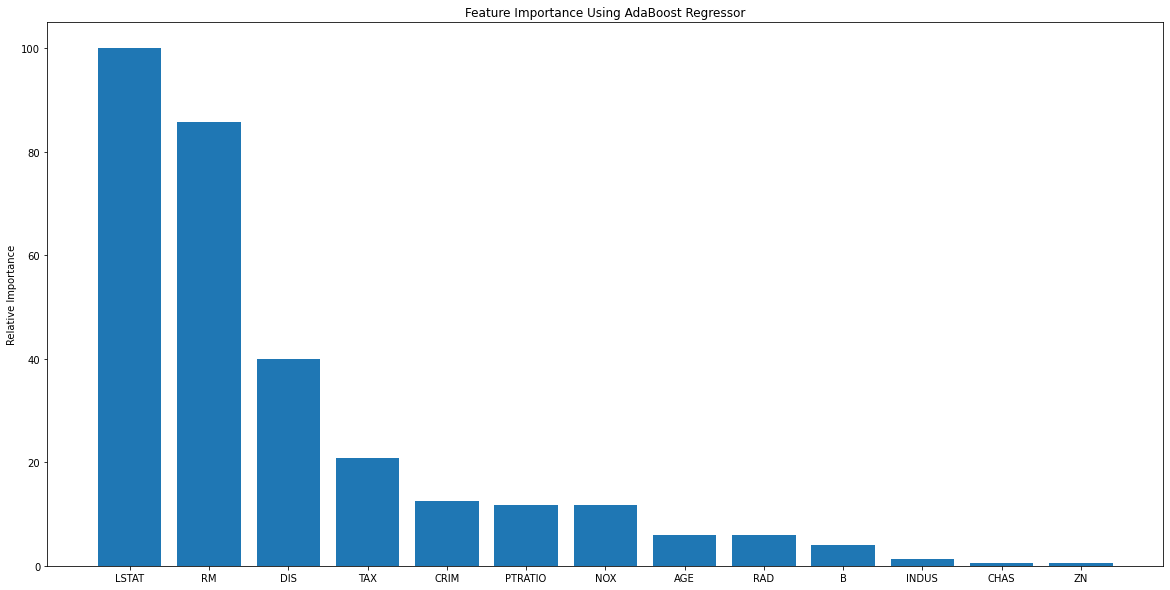

In [18]:
#Plot the bar graph
plt.figure(figsize = (20, 10))
plt.title('Feature Importance Using AdaBoost Regressor')

plt.bar(pos, feature_importances[index_sorted], align = 'center', tick_label = feature_names[index_sorted])

plt.ylabel('Relative Importance');

### Predicting traffic using an Extremely Random Forest Regressor

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

In [20]:
input_file = 'data/traffic_data.txt'

data = []
with open(input_file, 'r') as f:
    for line in f.readlines():
        items = line[:-1].split(',')
        data.append(items)
        
data = np.array(data)

In [21]:
data

array([['Tuesday', '00:00', 'San Francisco', 'no', '3'],
       ['Tuesday', '00:05', 'San Francisco', 'no', '8'],
       ['Tuesday', '00:10', 'San Francisco', 'no', '10'],
       ...,
       ['Thursday', '23:45', 'Arizona', 'no', '11'],
       ['Thursday', '23:50', 'Arizona', 'no', '14'],
       ['Thursday', '23:55', 'Arizona', 'no', '17']], dtype='<U13')

In [22]:
#Convert string data to numerical data
label_encoder = []

X_encoded = np.empty(data.shape)
for i, item in enumerate(data[0]):
    if item.isdigit():
        X_encoded[:, i] = data[:, i]
    else:
        label_encoder.append(LabelEncoder())
        X_encoded[:, i] = label_encoder[-1].fit_transform(data[:, i])

In [23]:
X = X_encoded[:, :-1].astype(int)
y = X_encoded[:, -1].astype(int)

In [24]:
#Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

In [25]:
#Extremely Random Forests Regressor
params = {'n_estimators': 100, 'max_depth': 4, 'random_state': 0}

regressor = ExtraTreesRegressor(**params)
regressor.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=4, random_state=0)

In [26]:
#Compute the regressor performance on test data
y_pred = regressor.predict(X_test)

mse = mean_absolute_error(y_test, y_pred)
print(f'Mean absolute error: {round(mse, 2)}')

Mean absolute error: 7.42


In [27]:
#Testing encoding on single data instance
test_datapoint = ['Saturday', '10:20', 'Atlanta', 'no']

test_datapoint_encoded = [-1] * len(test_datapoint)
count = 0

for i, item in enumerate(test_datapoint):
    if item.isdigit():
        test_datapoint_encoded[i] = int(test_datapoint[i])
    else:
        test_datapoint_encoded[i] = int(label_encoder[count].transform([test_datapoint[i]]))
        count += 1
        
test_datapoint_encoded = np.array(test_datapoint_encoded)

In [28]:
#Predict the output for the test datapoint
test_datapoint_pred = regressor.predict([test_datapoint_encoded])[0]
print(f'Predicted traffic: {int(test_datapoint_pred)}')

Predicted traffic: 26


### K-Means Clustering

In [29]:
from sklearn.cluster import KMeans

X = np.loadtxt('data/data_clustering.txt', delimiter = ',')

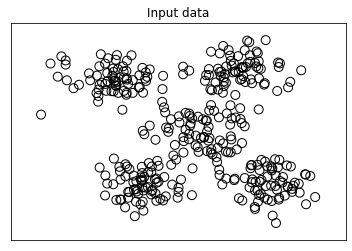

In [30]:
#Plot the input data

plt.figure()
plt.title('Input data')
plt.scatter(X[:, 0], X[:, 1], marker = 'o', facecolors = 'none', edgecolors = 'black', s = 80)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(());

In [31]:
num_clusters = 5

kmeans = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 10)

kmeans.fit(X)

KMeans(n_clusters=5)

In [32]:
#step size of the mesh
step_size = 0.01

x_vals, y_vals = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

In [33]:
#predict output labels for all the points on the grid
output = kmeans.predict(np.c_[x_vals.ravel(), y_vals.ravel()])

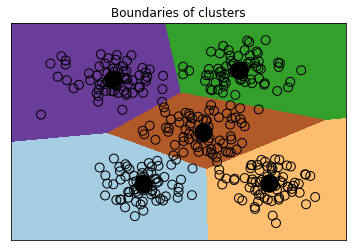

In [34]:
#plot the different regions with color

output = output.reshape(x_vals.shape)

plt.figure()
plt.title('Boundaries of clusters')

plt.imshow(output, interpolation = 'nearest', extent = (x_min, x_max, y_min, y_max),
          cmap = plt.cm.Paired, aspect = 'auto', origin = 'lower')

#Overlay the input points
plt.scatter(X[:, 0], X[:, 1], marker = 'o', facecolors = 'none', edgecolors = 'black', s = 80)

#Plot the centers of the clusters
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker = 'o', s = 210, linewidths = 4, color = 'black', zorder = 12,
            facecolors = 'black')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(());

### Mean-Shift Algorithm

In [35]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from itertools import cycle

In [36]:
X = np.loadtxt('data/data_clustering.txt', delimiter = ',')

In [38]:
#Estimate the bandwidth of X
bandwidth_X = estimate_bandwidth(X, quantile = 0.1, n_samples = len(X))

#Cluster data with MeanShift
meanshift_model = MeanShift(bandwidth = bandwidth_X, bin_seeding = True)
meanshift_model.fit(X)

MeanShift(bandwidth=1.3044799765090382, bin_seeding=True)

In [40]:
#Extract the centers of the clusters
cluster_centers = meanshift_model.cluster_centers_
print(f'Centers of clusters: \n{cluster_centers}')

Centers of clusters: 
[[2.95568966 1.95775862]
 [7.20690909 2.20836364]
 [2.17603774 8.03283019]
 [5.97960784 8.39078431]
 [4.99466667 4.65844444]]


In [41]:
#Estimate the number of clusters
labels = meanshift_model.labels_
num_clusters = len(np.unique(labels))

print(f'Number of clusters in input data: {num_clusters}')

Number of clusters in input data: 5


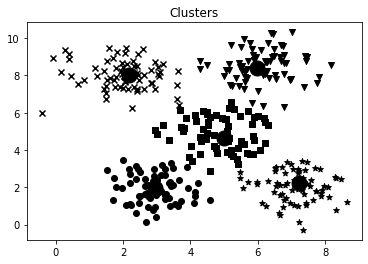

In [46]:
plt.figure()
plt.title('Clusters')

markers = 'o*xvs'
for i, marker in zip(range(num_clusters), markers):
    #Plot points that belong to the same cluster
    plt.scatter(X[labels == i, 0], X[labels == i, 1], marker = marker, color = 'black')
    
    #Plot the cluster center
    cluster_center = cluster_centers[i]
    plt.plot(cluster_center[0], cluster_center[1], marker = 'o', markerfacecolor = 'black', markeredgecolor = 'black',
            markersize = 15)

### Silhouette scores for estimating the quality of clustering

In [51]:
from sklearn.metrics import silhouette_score

In [52]:
X = np.loadtxt('data/data_quality.txt', delimiter = ',')

In [58]:
#Initialize variables
scores = []
values = np.arange(2, 10)

#Iterate through the defined range
for num_clusters in values:
    kmeans = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 10)
    kmeans.fit(X)
    
    score = silhouette_score(X, kmeans.labels_, metric = 'euclidean', sample_size = len(X))
    
    print(f'Number of clusters = {num_clusters}')
    print(f'Silhouette score = {score}\n')
    scores.append(score)

Number of clusters = 2
Silhouette score = 0.4776262487045446

Number of clusters = 3
Silhouette score = 0.5471742411734871

Number of clusters = 4
Silhouette score = 0.579480188968759

Number of clusters = 5
Silhouette score = 0.5890032635647954

Number of clusters = 6
Silhouette score = 0.6096904118954452

Number of clusters = 7
Silhouette score = 0.5525848802573345

Number of clusters = 8
Silhouette score = 0.5017024845879339

Number of clusters = 9
Silhouette score = 0.4538540911344362



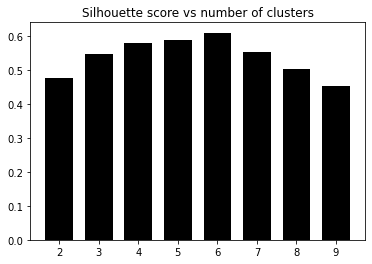

In [59]:
#Plot the silhouette scores
plt.figure()
plt.title('Silhouette score vs number of clusters')

plt.bar(values, scores, width = 0.7, color = 'black', align = 'center');

In [62]:
#Extract best score and optimal number of clusters
num_clusters = np.argmax(scores) + values[0]
print(f'Optimal number of clusters = {num_clusters}')

Optimal number of clusters = 6


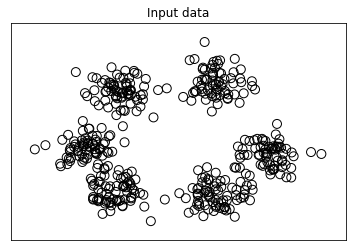

In [64]:
plt.figure()
plt.title('Input data')

plt.scatter(X[:, 0], X[:, 1], color = 'black', s = 80, marker = 'o', facecolors = 'none')

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.xticks(())
plt.yticks(());

### Gaussian Mixture Models

In [65]:
from matplotlib.patches import Ellipse

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

In [66]:
iris = datasets.load_iris()

X, y = datasets.load_iris(return_X_y = True)

In [68]:
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

5

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [73]:
#Extract the number of classes in the training data
num_classes = len(np.unique(y_train))

classifier = GaussianMixture(n_components = num_classes, covariance_type = 'full', init_params = 'kmeans', max_iter = 20)

#Initialize the GMM means
classifier.means_ = np.array([X_train[y_train == i].mean(axis = 0) for i in range(num_classes)])

classifier.fit(X_train)

GaussianMixture(max_iter=20, n_components=3)

<ipython-input-84-a30b84fa525b>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axis_handle = plt.subplot(1, 1, 1)


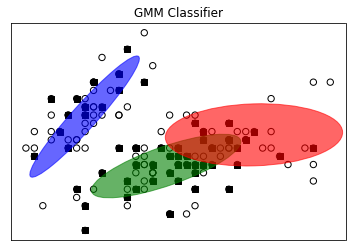

In [84]:
plt.figure()
plt.title('GMM Classifier')

colors = 'bgr'
for i, color in enumerate(colors):
    #Extract eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(classifier.covariances_[i][:2, :2])
    
    #Normalize the first eigenvector
    norm_vec = eigenvectors[0] / np.linalg.norm(eigenvectors[0])
    
    #Extract the angle of tilt for the ellipses to be rotated in order to accurately show the distribution
    angle = np.arctan2(norm_vec[1], norm_vec[0])
    angle = 180 * angle / np.pi
    
    #magnify the ellipses for visualization
    scaling_factor = 8
    eigenvalues *= scaling_factor
    
    #Draw the Ellipse
    ellipse = Ellipse(classifier.means_[i, :2], eigenvalues[0], eigenvalues[1], 180 + angle, color = color)
    
    axis_handle = plt.subplot(1, 1, 1)
    ellipse.set_clip_box(axis_handle.bbox)
    ellipse.set_alpha(0.6)
    axis_handle.add_artist(ellipse)
    
#Plot the data
for i, color in enumerate(colors):
    cur_data = iris.data[iris.target == i]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker = 'o', facecolors = 'none', edgecolors = 'black', s = 40)
    
    #Overlay the test data
    test_data = X_test[y_test == i]
    plt.scatter(test_data[:, 0], test_data[:, 1], marker = 's', facecolors = 'black', edgecolors = 'black', s = 40)
    
plt.xticks(())
plt.yticks(());

In [85]:
#Compute predictions for training and testing data
y_train_pred = classifier.predict(X_train)
accuracy_training = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
print(f'Accuracy on training data: {accuracy_training}')

y_test_pred = classifier.predict(X_test)
accuracy_testing = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
print(f'\nAccuracy on testing data: {accuracy_testing}')

Accuracy on training data: 92.22222222222223

Accuracy on testing data: 81.66666666666667
